# Function for closing the mesh (Necessary for calculating the volume

In [1]:
import numpy as np

'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
from ddgclib._particle_liquid_bridge_20240303 import *

In [2]:
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

    #boundary_top.append(vat)
    #print(f'vat = {vat}')
    #HC.V.remove(vat)
    #boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom, vat, vab

# Functions for the contact-angle calculation

In [3]:
def b_disc_angle(v, r, bV, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)

    vij = []
    for vn in v.nn:
        if vn in bV:
            continue
        else:
            vij.append(vn)

    if 0:
        for vn in v.nn:
            if vn in bV:
                vij.append(vn)


    E_ij = vij[0].x_a - v.x_a
    E_ik = vij[1].x_a - v.x_a
    E_ij_ik = np.cross(E_ij, E_ik)
    E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
    dir_vec = E_ij_ik / E_ij_ik_norm

    if np.dot(N_f0, dir_vec) < 0:
        dir_vec = - dir_vec

    #K_H_i = c_outd['K_H_i']
    HNdA_i = c_outd['HNdA_i']
    C_ij = c_outd['C_ij']
    #HN_i = np.sum(HNdA_i) / np.sum(C_ij)
    n_i = c_outd['n_i']
    HN_i = np.sum(np.dot(HNdA_i, n_i)) / np.sum(C_ij)
    K_H_i = (HN_i/ 2.0)**2


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
       # print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')
        print(f'phi_est = {phi_est * 180 / np.pi}')
        print(f'E_ij = {E_ij}')
        print(f'E_ik = {E_ik}')
        print(f'E_ij_ik = {E_ij_ik}')
        print(f'dir_vec = {dir_vec}')
        print(f'np.dot(E_ij_ik_norm, dir_vec) = {np.dot(E_ij_ik_norm, dir_vec)}')
        print(f'E_ij_ik_norm = {E_ij_ik_norm}')
        print(f'vij = {vij}')

    return phi_est, dir_vec, E_ij, E_ik, E_ij_ik# , de # (sum of edge lengths)

# Functions for Particle-Particle liquid bridge

In [4]:

def fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax, contact_angle = True, load_activated = False,itermax_load = 10, save_activated = False,volume_constraint = False, V_init = 1):
    '''
    length = length of the inital cone [m]
    tau = size of time step [-]
    d_l = diameter one the lower site of the initial cyliner [m]
    d_u = diameter one the upper site of the initial cyliner [m]
    refinement = number of refinement of the mesh [-]
    theta_c = value of the contact angle in radian [rad]
    gamma = surface_tension [N/m]
    breaking_condition = when this value is reached, the simulation is finished [m]
    itermax = another breaking condition depending on the iteration steps [-]
    contact_angle = is the contact angle actived
    load_activated = with this parameter you have the choice to load a complex instead of creating a new on.
        if load_activated = False: A new mesh will be generated
    itermax_load = number of iteration of the loading complex (necessary paramter for loading the complex function:
    save_activated = with this parameter you have the choice to save the final complex
        if save_activated=False: Nothing happens
        if save_activated=True: The complex will saved under a savename depending on the inital parameters
    '''

    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')

    r_l = d_l / 2
    r_u = d_u / 2

    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''
    if load_activated:
        load_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_load)+'.json'
        HC = Complex(3)
        HC.load_complex(load_filename)
    else:
        HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)


    # Define bottom boundary condition
    boundary_bottom = []
    N_f0_vectors_pairs = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)
    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

    # runvariable for the iteration tracking
    residual_iteration = 0

    #HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom)
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []
    contact_angle_list_bottom   = []
    contact_angle_list_top      = []

    '''
    ---------------------------------------------------------------------------------------------------------------------------
    From here, the optimization is started
    '''
    iters = 0
    while True:

        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')
            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")
            break
        '''
        Calculating the volume of the hole mesh in every volume
        '''

        if 1:
            V_current = 0
            number_v = 0
            HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom) # closing the boundary

            for v in HC.V:
                number_v += 1
                V_ijk = volume(v)
                V_current += np.sum(V_ijk)

            V_current = V_current/12
            print(f'V_current = {V_current}')
            volume_list.append(V_current)

            if 0: # V_init >= V_current and iters == 0:
                print(f'error: Volume constraint - Initial volume is bigger than the current volume')
                print(f'Proof the volume constraint!')
                print(f'Simulation will be canceled!')
                break
                dV = 0

            else:
                dV = (V_init-V_current)/V_init


            HC.V.remove(vat) # Open the boundary (Important, otherwise the angle-calculation will not work)
            HC.V.remove(vab) # Open the boundary (Important, otherwise the angle-calculation will not work)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}

        contact_angle_list_bottom_dummy = []
        contact_angle_list_top_dummy   = []
       # print(f'number of vertexes = {number_v}')
        cHC = copy.copy(HC)

        for v in cHC.V:
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])

            dV_dummy = dV
            # Define bottom boundary condition
            if v in set(boundary_bottom):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_bottom, print_out=False)
                contact_angle_list_bottom_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)

                dV_dummy = 0

                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) *gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0

                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Define top boundary condition
            if v in set(boundary_top):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_top, print_out=False)
               # contact_angle_list_top_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)
                dV_dummy = 0
                for vnn in v.nn:
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                        contact_angle_list_top_dummy.append(phi_est)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) * gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            #df = np.dot(df, N_f0)*N_f0
           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys() and contact_angle:
                db = v_boundary_interior[v.x]  # normalized(HNdA_i)[0]
              #  df = np.zeros_like(HNdA_i)
               # df[0] = 0
               # df[1] = 0
               # df[2] = 0
               # db[2] = 0
            else:
                pass

            # Step in time
            if iters < 1:
                db = np.zeros_like(HNdA_i)
            else:
                db = db



           # db = np.dot(db, dir_vec)*dir_vec
           # df = np.dot(df, N_f0)*N_f0
           # df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)

            #v_new = v.x_a - tau/2 * df  + tau/2 * db old

            if volume_constraint:
                dv = dV_dummy * N_f0
                #print(f'dV = {dV}')
                #print(f'dv = {dv}')

            else:
                dv = np.zeros_like(HNdA_i)

            if contact_angle: # contact angle constraint
                db = np.dot(db, N_f0)*N_f0
            else:
                db = np.zeros_like(HNdA_i)

            v_new = v.x_a - tau/2 * df  + tau/2 * db + tau/2 * dv

            '''
            if contact_angle: # condition if the contact angle is activated
                v_new = v.x_a - tau/2 * df  + tau/2 * db
            else:
                v_new = v.x_a - tau/2 * df
            '''

            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df+db))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        #contact_angle_list_bottom_dummy.append(phi_est) theta_p_approx * 180 / np.pi
        contact_angle_list_bottom.append(cal_average(contact_angle_list_bottom_dummy)* 180 / np.pi)
        contact_angle_list_top.append(cal_average(contact_angle_list_top_dummy)* 180 / np.pi)


        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break

        iters += 1

    if save_activated:
        if load_activated:
            itermax_save = itermax + itermax_load
        else:
            itermax_save = itermax

        save_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_save)+'.json'
        save_complex(HC, save_filename)
        print(f'Complex is saved under the name: {save_filename}.')

    result_dict = {}
    result_dict['HC'] = HC

    result_dict['iteration_list'] = iteration_list
    result_dict['df_list_min'] = df_list_min
    result_dict['df_list_max'] = df_list_max
    result_dict['volume_list'] = volume_list
    result_dict['contact_angle_list_bottom'] = contact_angle_list_bottom
    result_dict['contact_angle_list_top'] = contact_angle_list_top
    result_dict['N_f0_vectors_pairs'] = N_f0_vectors_pairs
    result_dict['dHNdA_list_min'] = dHNdA_list_min
    result_dict['dHNdA_list_max'] = dHNdA_list_max


    return result_dict


    #return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max)

   # return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max,contact_angle_list_top_dummy)





# Variation and execution of the particle-particle-liquid function

In [5]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
'''
d_l = 0.8e-3 # radian on the lower side of the cone
d_l = 1.6e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 0.36 * 3e-3
d_l = d_u
length = 0.7e-3 # length of the cone
length = 0.294 * 3e-3
'''



tau = 0.1    # Endtime for calculation
tau = 1    # Endtime for calculation
itermax = 0#100*1e3 #10*1e3



itermax_load = 25*1e3 # number of iteration of the loaded complex

'''
from Liam 19939
'''
#r_i = 1e-3 # Particle Radian
#r_i = 1.0
#gamma = 72.28

gamma = 2.45e-3  # N/m, surface tension of di-n-butyl phthalate/liquid paraffin mixture
r_i = 15e-3 # Particle Radian

angle = 10 # angle from the liquid bridge depending of the particle-radian
S = 0.1 # dimensionless seperation distance
#S = 0.3 # dimensionless seperation distance

y_i = np.sin(angle * np.pi/180.0) * r_i # calculated radian of the liquid bridge
r_l = y_i
r_u = r_l
length = S * r_i


# TEST angle:
theta_p = 61 * np.pi/180.0  # Three phase contact angle

'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''
#length = 2
#d_l = 1
#d_u = d_l


breaking_condition = 1e-9

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)
#fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_N(r_l, r_u, length, refinement, theta_p,tau, gamma, breaking_condition,itermax,contact_angle = False, save_activated=False, load_activated=False, itermax_load = itermax_load, volume_constraint=False, V_init= y_i**2 *np.pi * length * 0.01)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)


Simulation is started!
-------------------------------------
Mesh is generated. Optimization was not carried out because itermax = 0.


In [6]:
HC = dummy_parameter2['HC']
iteration_list = dummy_parameter2['iteration_list']
df_list_max = dummy_parameter2['df_list_max']
volume_list = dummy_parameter2['volume_list']
contact_angle_list_bottom = dummy_parameter2['contact_angle_list_bottom']

In [7]:
from ddgclib._plotting import *
plot_polyscope(HC)

if 0:
    load_filename = 'dl'+str(r_l*2)+'_du'+str(r_u*2)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_p)+'_tau'+str(tau)+'_itermax'+str(1000)+'.json'
    load_filename = 'dl0.002604722665003955_du0.002604722665003955_l0.0015_ref4_contactangle1.064650843716541_tau1_itermax100000.0.json'
    HC_load = Complex(3)
    HC_load.load_complex(load_filename)
    plot_polyscope(HC_load)


#plot_polyscope(dummy_parameter2['HC'])

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [8]:

#gamma

In [9]:
vlist = []


for v in HC.V:
    if (abs(v.x[0]) <= 1e-8) and (0.5e-3 <= v.x[1] <= 16):
        vlist.append(v.x)


sorted_list = sorted(vlist, key=lambda x: x[-1])

vlist_x = []
vlist_y = []
vlist_z = []

for v in sorted_list:
    vlist_x.append(v[0])
    vlist_y.append(v[1])
    vlist_z.append(v[2])

coordiante_dict = {'vlist_x':vlist_x, 'vlist_y':vlist_y, 'vlist_z':vlist_z}

In [10]:
#coordiante_dict_500 = coordiante_dict
#coordiante_dict_1000 = coordiante_dict
diameter = r_l * 1e3 * 2

rounded_diameter = round(diameter, 1)
rounded_length = round(length*1e3, 1)

iteration_max = 0

string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max)
string_loadname_x   = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(15000)

if 0:
    np.savetxt(string_savename + '_y'+ '.txt',coordiante_dict['vlist_y'])
    np.savetxt(string_savename + '_z'+ '.txt',coordiante_dict['vlist_z'])
    np.savetxt(string_savename + 'dfmax'+ '.txt',dummy_parameter2['df_list_max'])



# Loading df_max

In [11]:
load_iteration = 5000
string_loadname_x   = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(load_iteration) +'dfmax'+ '.txt'
df_list_5000              = np.loadtxt(string_loadname_x)

load_iteration = 15000
string_loadname_x   = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(load_iteration) +'dfmax'+ '.txt'
df_list_15000              = np.loadtxt(string_loadname_x)

load_iteration = 25000
string_loadname_x   = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(load_iteration) +'dfmax'+ '.txt'
df_list_25000              = np.loadtxt(string_loadname_x)

load_iteration = 35000
string_loadname_x   = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(load_iteration) +'dfmax'+ '.txt'
df_list_35000              = np.loadtxt(string_loadname_x)

combined_array = np.concatenate((df_list_5000, df_list_15000,df_list_25000, df_list_35000))

iteration_array = np.arange(len(combined_array))

C:\Users\Flo\AppData\Local\Temp\ipykernel_22800\3227428196.py:15: UserWarning: loadtxt: Empty input file: "d5.2mm_l1.5mm_iteration35000dfmax.txt"
  df_list_35000              = np.loadtxt(string_loadname_x)


## Loading the coordiantes

In [12]:
iteration_max_load = 0
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_0              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_0              = np.loadtxt(string_savename + '_z'+ '.txt')


iteration_max_load = 100
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_100              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_100              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 500
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_500              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_500              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 1000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_1000              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_1000              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 5000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_5000              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_5000              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 15000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_15000              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_15000              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 25000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_25000              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_25000              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 35000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_35000              = np.loadtxt(string_savename + '_y'+ '.txt')
z_coordinates_35000              = np.loadtxt(string_savename + '_z'+ '.txt')

iteration_max_load = 100000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_100000             = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0_y'+ '.txt')
z_coordinates_100000              = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0_z'+ '.txt')

iteration_max_load = 100000
string_savename     = 'd'+ str(rounded_diameter) + 'mm_' + 'l' + str(rounded_length) + 'mm_'  + 'iteration' +str(iteration_max_load)

y_coordinates_100000_ref4              = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0_yrefinement4'+ '.txt')
z_coordinates_100000_ref4              = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0_zrefinement4'+ '.txt')


# Plotting of the results

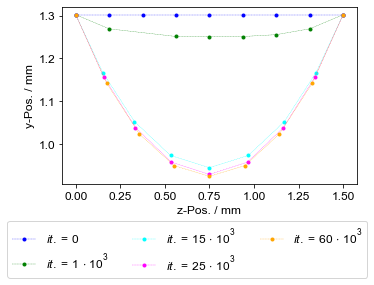

In [13]:
'''
Plot of the residual data
'''




plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

#fig_name = "contact_angle_notactivated10_20240219.png"
#fig_name = "example_calculation_lian_100000iteration_vergleich_refinement.png"
fig_name = "example_calculation_lian_100000iteration.png"
#fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(6, 5))


#fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(6, 3))

#ax[0].plot(vlist_z, vlist_y, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1)
#ax[0].plot(coordiante_dict['vlist_z'], coordiante_dict['vlist_y'], linestyle = '--', markersize = 5, marker = 'o', linewidth = 1)
if 0:
    ax[0].plot(z_coordinates_0, y_coordinates_0, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '0')
    ax[0].plot(z_coordinates_100, y_coordinates_100, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '100')
    ax[0].plot(z_coordinates_500, y_coordinates_500, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '500')
    ax[0].plot(z_coordinates_1000, y_coordinates_1000, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '1000')
    ax[0].plot(z_coordinates_5000, y_coordinates_5000, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '5000')
    ax[0].plot(z_coordinates_15000, y_coordinates_15000, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '15000')
    ax[0].plot(z_coordinates_25000, y_coordinates_15000, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1, label = '25000')

size_marker = 3
size_line = 0.3
size_line2 = 1

color_list = ['blue', 'green', 'red', 'cyan', 'magenta', 'black',
    'gray', 'grey', 'lightblue', 'lightgreen', 'lightred', 'lightcyan',
    'lightmagenta', 'lightyellow', 'darkblue', 'darkgreen', 'darkred',
    'darkcyan', 'darkmagenta', 'darkyellow', 'orange', 'purple', 'brown',
    'pink', 'olive', 'peach', 'limegreen', 'turquoise', 'indigo']

if 0:
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(6, 3))
    ax[0].plot(z_coordinates_0*1e3, y_coordinates_0*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = 'it.=0',color = color_list[0])
   ## ax[0].plot(z_coordinates_100*1e3, y_coordinates_100*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100')
   ## ax[0].plot(z_coordinates_500*1e3, y_coordinates_500*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '500')
    ax[0].plot(z_coordinates_1000*1e3, y_coordinates_1000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = 'it.=1000',color = color_list[1])
   # ax[0].plot(z_coordinates_5000*1e3, y_coordinates_5000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '5000',color = color_list[2])
    ax[0].plot(z_coordinates_15000*1e3, y_coordinates_15000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = 'it.=15000',color = color_list[3])
    ax[0].plot(z_coordinates_25000*1e3, y_coordinates_25000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '25000',color = color_list[4])
    ax[0].plot(z_coordinates_35000*1e3, y_coordinates_35000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '35000', color = color_list[5])
    ax[0].plot(z_coordinates_100000*1e3, y_coordinates_100000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100000',color = 'orange')
    #ax[0].plot(z_coordinates_100000_ref4*1e3, y_coordinates_100000_ref4*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100000 ref 4',color = color_list[6])
if 1:
    fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(5, 4))
    ax.plot(z_coordinates_0*1e3, y_coordinates_0*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = r'$it.\,=\,0$',color = color_list[0])
   ## ax[0].plot(z_coordinates_100*1e3, y_coordinates_100*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100')
   ## ax[0].plot(z_coordinates_500*1e3, y_coordinates_500*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '500')
    ax.plot(z_coordinates_1000*1e3, y_coordinates_1000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = r'$it.\,=\,1\,\cdot\,10^3$',color = color_list[1])
   # ax[0].plot(z_coordinates_5000*1e3, y_coordinates_5000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '5000',color = color_list[2])
    ax.plot(z_coordinates_15000*1e3, y_coordinates_15000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = r'$it.\,=\,15\,\cdot\,10^3$',color = color_list[3])
    ax.plot(z_coordinates_25000*1e3, y_coordinates_25000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = r'$it.\,=\,25\,\cdot\,10^3$',color = color_list[4])
    #ax.plot(z_coordinates_35000*1e3, y_coordinates_35000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '$ 35 \cdot 10^3$', color = color_list[5])
    ax.plot(z_coordinates_100000*1e3, y_coordinates_100000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = r'$it.\,=\,60\,\cdot\,10^3$',color = 'orange')
    #ax[0].plot(z_coordinates_100000_ref4*1e3, y_coordinates_100000_ref4*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100000 ref 4',color = color_list[6])
    ax.set_xlabel("z-Pos. / mm")
    ax.set_ylabel("y-Pos. / mm")

if 0:
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(6, 3))
   # ax[0].plot(z_coordinates_0*1e3, y_coordinates_0*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '0',color = color_list[0])
   ## ax[0].plot(z_coordinates_100*1e3, y_coordinates_100*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '100')
   ## ax[0].plot(z_coordinates_500*1e3, y_coordinates_500*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '500')
   # ax[0].plot(z_coordinates_1000*1e3, y_coordinates_1000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '1000',color = color_list[1])
   # ax[0].plot(z_coordinates_5000*1e3, y_coordinates_5000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '5000',color = color_list[2])
   # ax[0].plot(z_coordinates_15000*1e3, y_coordinates_15000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '15000',color = color_list[3])
   # ax[0].plot(z_coordinates_25000*1e3, y_coordinates_25000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '25000',color = color_list[4])
   ## ax[0].plot(z_coordinates_35000*1e3, y_coordinates_35000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = '35000')
    ax[0].plot(z_coordinates_100000*1e3, y_coordinates_100000*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = 'ref. = 3',color = 'orange')
    ax[0].plot(z_coordinates_100000_ref4*1e3, y_coordinates_100000_ref4*1e3, linestyle = '--', markersize = size_marker, marker = 'o', linewidth = size_line, label = 'ref. = 4',color = 'green')


# ax[0].plot(coordiante_dict_500['vlist_z'], coordiante_dict_1000['vlist_y'], linestyle = '--', markersize = size_marker, marker = 'o', linewidth = 1)
#ax[0].hlines(50,-10,2300, colors = 'red', linestyle = '--')
#*1e3
#ax[0].set_yscale('log')

#ax[1].plot(iteration_list, contact_angle_list_top)
#ax[1].plot(iteration_list, df_list_max)
if 0:
    #ax[1].plot(iteration_array, combined_array)
    df_list_100000              = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0dfmax.txt')
    iteration_array = np.arange(0,len(df_list_100000),1)
    ax[1].plot(iteration_array, df_list_100000*1e3, linestyle = '-', markersize = size_marker, marker = ' ', linewidth = size_line2, label = 'ref. = 3',color = 'orange')

if 0:
    df_list_100000_ref4              = np.loadtxt('d5.2mm_l1.5mm_iteration100000.0dfmaxrefinement4.txt')
    iteration_array_ref4 = np.arange(0,len(df_list_100000_ref4),1)
    ax[1].plot(iteration_array_ref4, df_list_100000_ref4*1e3,linestyle = '-', markersize = size_marker, marker = ' ', linewidth = size_line2, label = 'ref. = 4',color = 'green')
    ax[1].hlines(1e-6,-10,len(df_list_100000_ref4)+1e5, colors = 'red', linestyle = '--', linewidth = 0.3, label = 'cancel cond.')
#ax[1].plot(iteration_list, dHNdA_list_min)
#
#hlines(y, xmin, xmax, colors=None, linestyles='solid'

if 0:
    ax[0].set_title('(a)')
    ax[1].set_title('(b)')

    ax[0].set_xlabel("z-Pos. / mm")
    ax[0].set_ylabel("y-Pos. / mm")

    ax[1].set_xlabel("iteration / -")
    ax[1].set_ylabel('$\Delta f_\mathregular{max}$  / mm ')

    #ax[0].set_ylim(45, 91)
    #ax[0].set_xlim(0, itermax)


    ax[1].set_yscale('log')
    #ax[1].set_ylim(0, 91)
    ax[1].set_xlim(0, iteration_array[-1])
    #ax[0].legend()

#plt.tight_layout()

lines, labels = fig.axes[-1].get_legend_handles_labels() #labels von dem letzten ax Objekt
plt.figlegend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0), bbox_transform=plt.gcf().transFigure, ncol=3)
fig.tight_layout(rect=(0,0.2,1,1)) #Platz für Legende lassen


fig.savefig(fig_name,dpi = 400)

In [14]:

print(min(y_coordinates_100000_ref4))

print(y_coordinates_100000_ref4[0])

print(len(df_list_100000))

print(len(df_list_100000_ref4))

0.0010021129485973477
0.0013023613325019775


NameError: name 'df_list_100000' is not defined

In [15]:
'''
Some not ready defined functions
'''
def b_force(v, theta_p, print_out=True):
    """
    The force on the three-phase contact angle
    Theta_i: Estimated sector angle of vertex i
    theta_p: Equilibrium three-phase contact angle
    """


    phi_est, l_a = b_disc_angle(v)
    # Compute boundary forces
    # N m-1
    gamma_bt = gamma * (np.cos(phi_est)
                        - np.cos(theta_p)) * np.array([0, 0, 1.0])

    if print_out:
        print(f'phi_est  = {phi_est * 180 / np.pi}')
        #print(f'dK[i] = {dK[i]}')
    return gamma_bt


def b_move_vertex(v, Theta_i, theta_p, print_out=True):
    """
    Move the boundary vertex
    """

    F_bt = gamma_bt * l_a  # N
    new_vx = v.x + 1e-1 * F_bt
    new_vx = tuple(new_vx)
    HC.V.move(v, new_vx)
    bV_new.add(HC.V[new_vx])

In [16]:
'''
Plotting of the normvecs (dir_vecs)
'''

plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

NameError: name 'N_f0_vectors_pairs' is not defined

# Using the Function